# Google drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파일 가져오기

In [2]:
!unzip /content/drive/MyDrive/rokey/rokey-boot-camp-mini-competition-2-week-2.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Kaggle03/train/toy_poodle/113785.JPEG  
  inflating: Kaggle03/train/toy_poodle/113786.JPEG  
  inflating: Kaggle03/train/toy_poodle/113787.JPEG  
  inflating: Kaggle03/train/toy_poodle/113788.JPEG  
  inflating: Kaggle03/train/toy_poodle/113789.JPEG  
  inflating: Kaggle03/train/toy_poodle/113790.JPEG  
  inflating: Kaggle03/train/toy_poodle/113791.JPEG  
  inflating: Kaggle03/train/toy_poodle/113792.JPEG  
  inflating: Kaggle03/train/toy_poodle/113793.JPEG  
  inflating: Kaggle03/train/toy_poodle/113794.JPEG  
  inflating: Kaggle03/train/toy_poodle/113795.JPEG  
  inflating: Kaggle03/train/toy_poodle/113796.JPEG  
  inflating: Kaggle03/train/toy_poodle/113797.JPEG  
  inflating: Kaggle03/train/toy_poodle/113798.JPEG  
  inflating: Kaggle03/train/toy_poodle/113799.JPEG  
  inflating: Kaggle03/train/toy_poodle/113800.JPEG  
  inflating: Kaggle03/train/toy_poodle/113801.JPEG  
  inflating: Kaggle03/train/toy_poodle/113802.JPEG  
  inflatin

# 파일 구조 확인

In [3]:
!ls Kaggle03/


name2id.json  test  train


In [4]:
!ls Kaggle03/train

affenpinscher			EntleBucher		     Old_English_sheepdog
Afghan_hound			Eskimo_dog		     otterhound
Airedale			flat-coated_retriever	     papillon
American_Staffordshire_terrier	French_bulldog		     Pekinese
Appenzeller			German_shepherd		     Pembroke
Australian_terrier		German_short-haired_pointer  Pomeranian
basenji				giant_schnauzer		     pug
basset				golden_retriever	     redbone
beagle				Gordon_setter		     Rhodesian_ridgeback
Bedlington_terrier		Great_Dane		     Rottweiler
Bernese_mountain_dog		Greater_Swiss_Mountain_dog   Saint_Bernard
black-and-tan_coonhound		Great_Pyrenees		     Saluki
Blenheim_spaniel		groenendael		     Samoyed
bloodhound			Ibizan_hound		     schipperke
bluetick			Irish_setter		     Scotch_terrier
Border_collie			Irish_terrier		     Scottish_deerhound
Border_terrier			Irish_water_spaniel	     Sealyham_terrier
borzoi				Irish_wolfhound		     Shetland_sheepdog
Boston_bull			Italian_greyhound	     Shih-Tzu
Bouvier_des_Flandres		Japanese_spaniel	     Siberian_h

In [5]:
!ls Kaggle03/test

000000.JPEG  000843.JPEG  001686.JPEG  002529.JPEG  003372.JPEG  004215.JPEG  005058.JPEG
000001.JPEG  000844.JPEG  001687.JPEG  002530.JPEG  003373.JPEG  004216.JPEG  005059.JPEG
000002.JPEG  000845.JPEG  001688.JPEG  002531.JPEG  003374.JPEG  004217.JPEG  005060.JPEG
000003.JPEG  000846.JPEG  001689.JPEG  002532.JPEG  003375.JPEG  004218.JPEG  005061.JPEG
000004.JPEG  000847.JPEG  001690.JPEG  002533.JPEG  003376.JPEG  004219.JPEG  005062.JPEG
000005.JPEG  000848.JPEG  001691.JPEG  002534.JPEG  003377.JPEG  004220.JPEG  005063.JPEG
000006.JPEG  000849.JPEG  001692.JPEG  002535.JPEG  003378.JPEG  004221.JPEG  005064.JPEG
000007.JPEG  000850.JPEG  001693.JPEG  002536.JPEG  003379.JPEG  004222.JPEG  005065.JPEG
000008.JPEG  000851.JPEG  001694.JPEG  002537.JPEG  003380.JPEG  004223.JPEG  005066.JPEG
000009.JPEG  000852.JPEG  001695.JPEG  002538.JPEG  003381.JPEG  004224.JPEG  005067.JPEG
000010.JPEG  000853.JPEG  001696.JPEG  002539.JPEG  003382.JPEG  004225.JPEG  005068.JPEG
000011.JPE

In [6]:
import json
import random
from glob import glob
from collections import defaultdict
from typing import Any, Callable, List, Optional, Type, Union
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from PIL import Image, ImageFilter
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint


# DataLoader

압축푼 직후에는 파일적용이 되지 않아 FileNotFoundError 오류가 뜰 수 있습니다.

약간 대기 후 다시 실행하면 됩니다.

img_path = ["Kaggle03/train/***/000001.JPEG",
"Kaggle03/train/***/000002.JPEG",
"Kaggle03/train/***/000003.JPEG",
"Kaggle03/train/***/000004.JPEG",
"Kaggle03/train/***/000005.JPEG",
...]


In [7]:

# 시드 설정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # 원하는 시드 값 입력

class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        self.transform = transform

        # JSON 파일에서 클래스 매핑 로드
        with open(f"{data_path}/name2id.json") as f:
            self.name2id = json.load(f)

        # 이미지 경로 설정
        if self.train:
            self.img_path = glob(f"{data_path}/train/*/*.JPEG")
            self.labels = [self.name2id[d.split("/")[-2]] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test/*.JPEG")
            self.labels = None

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        img = self.transform(img) if self.transform else img

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]


# 데이터 경로와 변환 설정
data_path = "./Kaggle03"

transform_train = transforms.Compose([
    # 1. 이미지 크기 조정 및 기본 데이터 증강
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # 랜덤 크롭 후 224x224 리사이즈
    transforms.RandomHorizontalFlip(p=0.5),                            # 수평 반전
    transforms.RandomVerticalFlip(p=0.5),                              # 수직 반전
    transforms.RandomRotation(20),                                     # 랜덤 회전 (최대 20도)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 조정
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),          # 이동
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),         # 랜덤 원근 변환

    # 2. 최종 이미지 크기 조정
    transforms.Resize((224, 224)),                                     # 이미지 크기 조정 (224x224)

    # 3. Tensor 변환 및 정규화
    transforms.ToTensor(),                                             # 이미지를 Tensor로 변환
    transforms.RandomErasing(p=0.5),                                   # 랜덤 영역 지우기 (컷아웃)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                   # 평균값으로 정규화
                         std=[0.229, 0.224, 0.225])                    # 표준편차로 정규화
])

transform_test = transforms.Compose([

    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색감 증강 추가
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화 추가
])

# train용 dataset과 validation용 dataset을 개별적으로 생성
train_dataset = MyDataset(data_path, train=True, transform=transform_train)
val_dataset = MyDataset(data_path, train=True, transform=transform_test)

# train/val split
train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))),
    test_size=0.1,
    random_state=42,
    stratify=train_dataset.labels
)

# 훈련 데이터에 대한 클래스 가중치 계산
train_labels = [train_dataset.labels[i] for i in train_indices]
class_counts = np.bincount(train_labels)  # 각 클래스의 샘플 수를 계산
class_weights = 1.0 / class_counts  # 각 클래스의 가중치 계산
class_weights[np.isinf(class_weights)] = 0  # 가중치가 무한대인 경우 0으로 설정
sample_weights = class_weights[train_labels]  # 각 샘플의 가중치 할당

# WeightedRandomSampler 설정
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Subset을 사용하여 훈련 및 검증 데이터셋 생성
train_data = Subset(train_dataset, train_indices)
val_data = Subset(val_dataset, val_indices)
batch_size = 128
# train_loader와 val_loader 설정
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

# 테스트 데이터셋 로드
test_data = MyDataset(data_path, train=False, transform=transform_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 각 배치에서 클래스 분포 확인
for batch in train_loader:
    images, labels = batch
    batch_class_distribution = {label.item(): (labels == label).sum().item() for label in set(labels.numpy())}

    print("Batch Class Distribution:")
    pprint(batch_class_distribution)  # 가독성을 높여 출력
    break  # 첫 번째 배치만 확인


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch Class Distribution:
{0: 1,
 3: 3,
 4: 1,
 5: 1,
 6: 1,
 8: 1,
 9: 1,
 10: 3,
 12: 2,
 13: 1,
 14: 1,
 16: 1,
 18: 1,
 19: 1,
 22: 1,
 24: 2,
 25: 1,
 26: 1,
 27: 1,
 28: 2,
 31: 1,
 32: 1,
 33: 1,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 40: 1,
 41: 1,
 43: 2,
 44: 1,
 45: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 2,
 51: 1,
 53: 2,
 54: 1,
 55: 2,
 56: 1,
 57: 2,
 58: 1,
 59: 1,
 60: 2,
 61: 2,
 64: 4,
 65: 1,
 66: 1,
 67: 2,
 68: 1,
 69: 2,
 72: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 2,
 81: 6,
 83: 2,
 84: 1,
 85: 1,
 86: 2,
 89: 1,
 90: 2,
 91: 3,
 92: 2,
 93: 2,
 95: 1,
 96: 2,
 98: 1,
 100: 3,
 102: 1,
 104: 3,
 105: 1,
 106: 1,
 108: 1,
 109: 1,
 110: 2,
 111: 1,
 112: 4,
 117: 1}


In [8]:
print("총 학습 데이터 수",len(train_data))
print("총 val 데이터 수",len(val_data))
print("총 test 데이터 수",len(test_data))

print("배치 사이즈  ", batch_size)

print("배치시 총 학습 데이터 수",len(train_loader))
print("배치시 총 val 데이터 수",len(val_loader))
print("배치시 총 test 데이터 수",len(test_loader))

총 학습 데이터 수 133085
총 val 데이터 수 14788
총 test 데이터 수 5900
배치 사이즈   128
배치시 총 학습 데이터 수 1040
배치시 총 val 데이터 수 116
배치시 총 test 데이터 수 47


In [9]:
# 각 데이터셋의 변환을 출력
print("Train Transform:", train_data.dataset.transform)
# Validation 데이터셋에 대한 변환 확인
val_dataset_transform = val_data.dataset.transform  # Subset의 dataset 접근
print("Validation Transform:", val_dataset_transform)
# Test 데이터셋에 대한 변환 확인
print("Test Transform:", test_data.transform)

print("\nTrain Loader Attributes:", dir(train_loader),"\n")

# DataLoader에서 dataset 속성을 통해 변환 확인
print("Train Loader Transform:", train_loader.dataset.dataset.transform)  # Subset의 dataset 접근
print("Validation Loader Transform:", val_loader.dataset.dataset.transform)  # Subset의 dataset 접근
print("Test Loader Transform:", test_loader.dataset.transform)

# DataLoader 속성 확인


Train Transform: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    RandomPerspective(p=0.5)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Validation Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456,

Label 5 - Group 1: 5 images


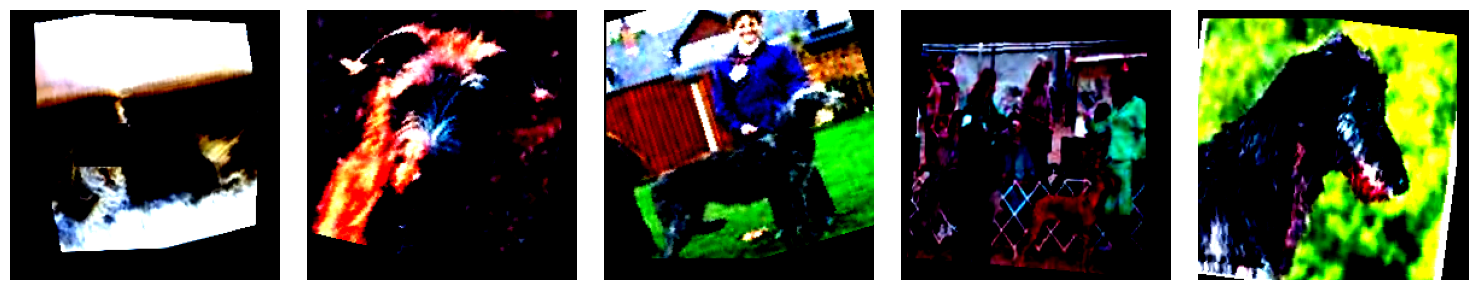

Label 5 - Group 2: 5 images


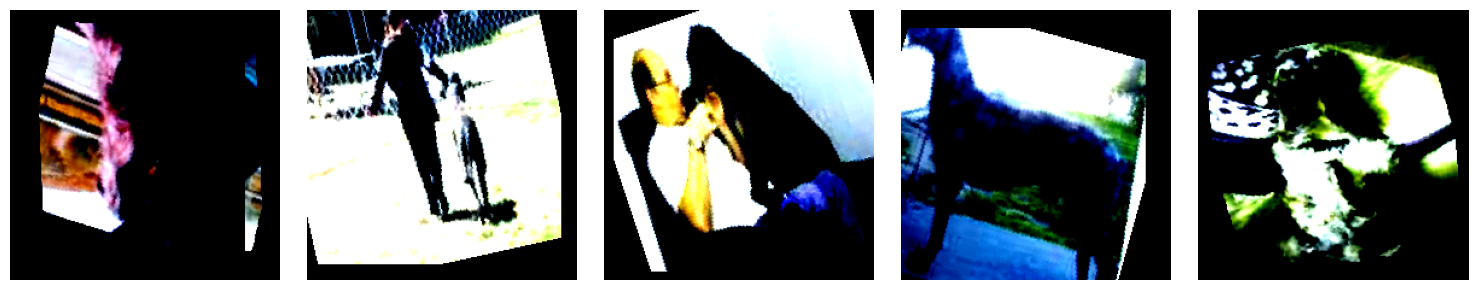

Label 5 - Group 3: 3 images


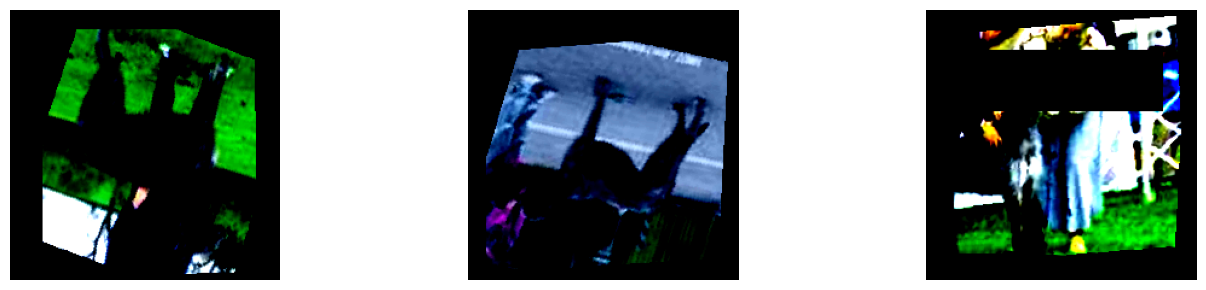

In [10]:
# n장을 뽑도록 설정
n = 13  # 원하는 장 수로 설정 가능
k = 5  # 선택한 라벨

# DataLoader에서 샘플링하여 선택한 라벨 k의 이미지 n개씩 출력
def sample_images_by_label(dataloader, label, num_samples):
    sampled_images = []
    for images, labels in dataloader:
        label_indices = (labels == label).nonzero(as_tuple=True)[0].tolist()  # 라벨 k의 인덱스 찾기
        if len(label_indices) > 0:
            sampled_indices = random.sample(label_indices, min(num_samples, len(label_indices)))  # n개의 인덱스 랜덤 선택
            sampled_images.extend([images[i] for i in sampled_indices])  # 선택한 인덱스의 이미지 가져오기
        if len(sampled_images) >= num_samples:
            break  # 원하는 수의 이미지를 수집하면 종료
    return sampled_images[:num_samples]

# 선택한 라벨 k의 이미지 n개 샘플링
images_to_display = sample_images_by_label(train_loader, k, n)

# 샘플링한 이미지 출력
num_groups = len(images_to_display) // 5 + (len(images_to_display) % 5 > 0)  # 5장씩 그룹 수 계산
for i in range(num_groups):
    group_images = images_to_display[i*5:(i+1)*5]  # 5장의 이미지를 그룹으로 선택
    print(f"Label {k} - Group {i+1}: {len(group_images)} images")

    fig, axes = plt.subplots(1, len(group_images), figsize=(15, 3))  # 1행 len(group_images)열의 서브플롯 생성
    for img, ax in zip(group_images, axes):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [11]:
def save_model(model, save_path):
    """
    모델의 상태를 저장하는 함수.

    Parameters:
    model (torch.nn.Module): 저장할 PyTorch 모델
    save_path (str): 모델을 저장할 경로
    """
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

def load_model(model, load_path):
    """
    저장된 모델의 상태를 불러오는 함수.

    Parameters:
    model (torch.nn.Module): 불러올 PyTorch 모델 인스턴스
    load_path (str): 모델을 불러올 경로
    """
    model.load_state_dict(torch.load(load_path))
    model.eval()  # 평가 모드로 전환
    print(f'Model loaded from {load_path}')


# Model

In [12]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [13]:
model_res_18 = ResNet(BasicBlock,[2, 2, 2, 2],118)

In [14]:
model = model_res_18
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# # 모델 가중치 불러오기
# model_cur_path = '/content/drive/MyDrive/rokey/model_res_18_cur.pth'
# if os.path.exists(model_cur_path):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.load_state_dict(torch.load(model_cur_path, map_location=device, weights_only=True))
#     print(f"{model_cur_path}에서 모델을 불러왔습니다.")
# else:
#     print(f"{model_cur_path} 파일이 존재하지 않습니다. 새로 훈련합니다.")

In [15]:
import torch

def save_model(model, save_path, optimizer, criterion):
    """
    모델의 상태를 저장하는 함수.

    Parameters:
    model (torch.nn.Module): 저장할 PyTorch 모델
    save_path (str): 모델을 저장할 경로
    optimizer (torch.optim.Optimizer): 최적화기
    criterion (str): 손실 함수 이름 (예: 'CrossEntropyLoss')
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'criterion': criterion,  # criterion은 문자열로 저장
    }
    torch.save(checkpoint, save_path)  # 전체 체크포인트 저장
    print(f'Model saved to {save_path}')

def load_model(model, load_path, optimizer):
    """
    저장된 모델의 상태를 불러오는 함수.

    Parameters:
    model (torch.nn.Module): 불러올 PyTorch 모델 인스턴스
    load_path (str): 모델을 불러올 경로
    optimizer (torch.optim.Optimizer): 최적화기
    """
    checkpoint = torch.load(load_path)  # 체크포인트 불러오기
    model.load_state_dict(checkpoint['model_state_dict'])  # 모델 상태 불러오기
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # 최적화기 상태 불러오기
    criterion = checkpoint['criterion']  # 손실 함수 이름 불러오기
    print(f'Model loaded from {load_path}')


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



num_epochs = 100
model_save_path = '/content/drive/MyDrive/rokey/last/model_res_18_{}.pth'
model_cur_path = '/content/drive/MyDrive/rokey/last/model_res_18_cur.pth'
total_step = len(train_loader)
# JSON 파일 경로
json_file_path = '/content/drive/MyDrive/rokey/last/loss_accuracy.json'

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# 손실 및 정확도를 저장할 리스트 초기화
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# JSON 파일이 존재하는지 확인하고 읽기
if os.path.exists(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
        train_losses = data.get('train_losses', [])
        val_losses = data.get('val_losses', [])
        train_accuracies = data.get('train_accuracies', [])
        val_accuracies = data.get('val_accuracies', [])
else:
    print(f"{json_file_path} 파일이 존재하지 않아 새로 생성합니다.")

# 시작 에폭 지정 (기본값 0)
start_epoch = len(train_losses)


In [17]:
if os.path.exists(model_cur_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model(model, model_cur_path, optimizer)  # 모델과 옵티마이저 상태 불러오기
else:
    print(f"{model_cur_path} 파일이 존재하지 않습니다. 새로 훈련합니다.")


<ipython-input-15-7d8520c89424>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)  # 체크포인트 불러오기


Model loaded from /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


In [18]:
import json
import os


for epoch in range(start_epoch, start_epoch + num_epochs):
    total_loss = 0
    correct_train = 0  # 훈련 데이터의 정확도 계산을 위한 변수
    total_train = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()  # 학습 모드로 전환
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 훈련 정확도 계산
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        pbar.set_description(f'Epoch [{epoch+1}/{start_epoch + num_epochs}], Loss: {round(total_loss / (i+1), 4)}')

    # 에폭이 끝난 후 손실 및 정확도 기록
    train_losses.append(total_loss / total_step)
    train_accuracies.append(100 * correct_train / total_train)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # 검증 손실 계산
            val_loss += loss.item()  # 검증 손실 누적

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss / len(val_loader))  # 평균 검증 손실 추가

    print(f'훈련 정확도: {train_accuracies[-1]} %, 검증 정확도: {val_accuracy} %')

    # 에폭이 25의 배수일 때 모델 저장
    if (epoch + 1) % 25 == 0:
        save_model(model, model_save_path.format(epoch + 1),optimizer,criterion)  # 모델 저장
        print('모델 세이브 ', epoch)
    save_model(model, model_cur_path,optimizer,criterion)  # 모델 저장
    # /content/drive/MyDrive/rokey/
    # 손실 및 정확도를 JSON 파일로 저장
    with open('/content/drive/MyDrive/rokey/loss_accuracy.json', 'w') as f:
        json.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, f)



Epoch [32/131], Loss: 2.4697: 100%|██████████| 1040/1040 [21:17<00:00,  1.23s/it]


훈련 정확도: 36.22572040425292 %, 검증 정확도: 33.04030294833649 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [33/131], Loss: 2.4395: 100%|██████████| 1040/1040 [21:19<00:00,  1.23s/it]


훈련 정확도: 36.58639215538941 %, 검증 정확도: 35.697863132269404 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [34/131], Loss: 2.5738: 100%|██████████| 1040/1040 [21:31<00:00,  1.24s/it]


훈련 정확도: 33.97001916068678 %, 검증 정확도: 35.13659724100622 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [35/131], Loss: 2.5504: 100%|██████████| 1040/1040 [20:54<00:00,  1.21s/it]


훈련 정확도: 34.56512755006199 %, 검증 정확도: 36.32675142007033 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [36/131], Loss: 2.556: 100%|██████████| 1040/1040 [21:22<00:00,  1.23s/it]


훈련 정확도: 34.47646241124094 %, 검증 정확도: 36.31322694076278 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [37/131], Loss: 2.5592: 100%|██████████| 1040/1040 [21:28<00:00,  1.24s/it]


훈련 정확도: 34.360746891084645 %, 검증 정확도: 35.69110089261564 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [38/131], Loss: 2.5363: 100%|██████████| 1040/1040 [21:17<00:00,  1.23s/it]


훈련 정확도: 34.931059097569225 %, 검증 정확도: 38.24046524208818 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [39/131], Loss: 2.5298: 100%|██████████| 1040/1040 [21:37<00:00,  1.25s/it]


훈련 정확도: 35.14220235188038 %, 검증 정확도: 36.25236678387882 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [40/131], Loss: 2.5179: 100%|██████████| 1040/1040 [21:13<00:00,  1.22s/it]


훈련 정확도: 35.33155502122703 %, 검증 정확도: 38.20665404381931 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [41/131], Loss: 2.4965: 100%|██████████| 1040/1040 [21:21<00:00,  1.23s/it]


훈련 정확도: 35.8207160837059 %, 검증 정확도: 38.598863943738166 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [42/131], Loss: 2.495: 100%|██████████| 1040/1040 [21:08<00:00,  1.22s/it]


훈련 정확도: 35.64939700191607 %, 검증 정확도: 37.37489856640519 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [43/131], Loss: 2.4797: 100%|██████████| 1040/1040 [20:57<00:00,  1.21s/it]


훈련 정확도: 36.076943306909115 %, 검증 정확도: 36.86773059237219 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [44/131], Loss: 2.4541: 100%|██████████| 1040/1040 [20:45<00:00,  1.20s/it]


훈련 정확도: 36.67881429161814 %, 검증 정확도: 35.94806599945902 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [45/131], Loss: 2.4655: 100%|██████████| 1040/1040 [20:51<00:00,  1.20s/it]


훈련 정확도: 36.442123454934816 %, 검증 정확도: 39.011360562618336 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [46/131], Loss: 2.4463: 100%|██████████| 1040/1040 [21:09<00:00,  1.22s/it]


훈련 정확도: 36.756959837697714 %, 검증 정확도: 37.97673789559102 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [47/131], Loss: 2.4385: 100%|██████████| 1040/1040 [21:34<00:00,  1.25s/it]


훈련 정확도: 36.96209189615659 %, 검증 정확도: 38.38923451447119 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [48/131], Loss: 2.4295: 100%|██████████| 1040/1040 [21:40<00:00,  1.25s/it]


훈련 정확도: 37.312995454033135 %, 검증 정확도: 39.43061942115229 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [49/131], Loss: 2.4257: 100%|██████████| 1040/1040 [21:33<00:00,  1.24s/it]


훈련 정확도: 37.25664049291806 %, 검증 정확도: 37.09764674060049 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [50/131], Loss: 2.4156: 100%|██████████| 1040/1040 [21:13<00:00,  1.22s/it]


훈련 정확도: 37.543675094864184 %, 검증 정확도: 41.276710846632405 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_50.pth
모델 세이브  49
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [51/131], Loss: 2.4035: 100%|██████████| 1040/1040 [20:54<00:00,  1.21s/it]


훈련 정확도: 37.64436262538979 %, 검증 정확도: 38.95050040573438 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [52/131], Loss: 2.3933: 100%|██████████| 1040/1040 [21:21<00:00,  1.23s/it]


훈련 정확도: 37.98474659052485 %, 검증 정확도: 38.99107384365702 %
Model saved to /content/drive/MyDrive/rokey/last/model_res_18_cur.pth


Epoch [53/131], Loss: 2.3943:  35%|███▌      | 364/1040 [07:22<13:41,  1.21s/it]


KeyboardInterrupt: 

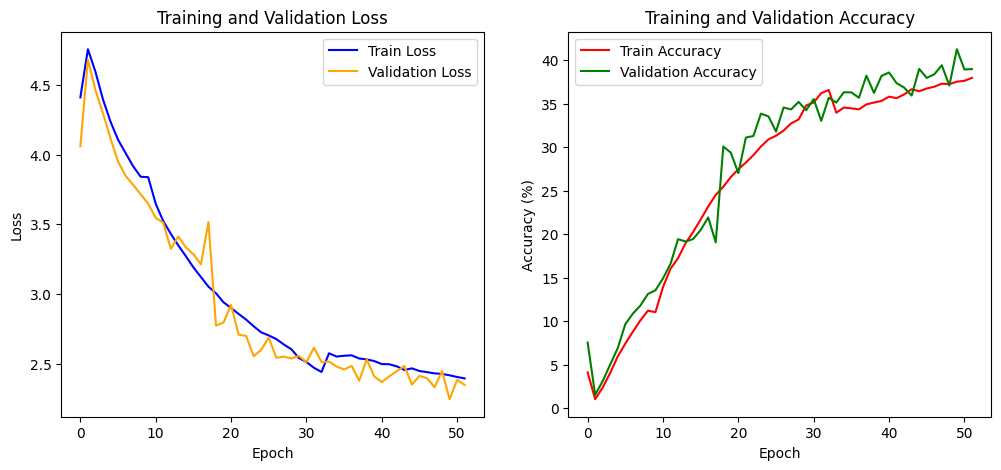

In [19]:
# 훈련 손실 및 검증 손실과 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='red')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


# Evaluation

Confusion Matrix:
 [[39  0  0 ...  0  0  2]
 [ 0 29  1 ...  0  0  1]
 [ 0  3 42 ...  1  0  0]
 ...
 [ 0  0  0 ... 76  0  0]
 [ 0  0  0 ...  0 72  0]
 [ 6  0  0 ...  0  0 38]]


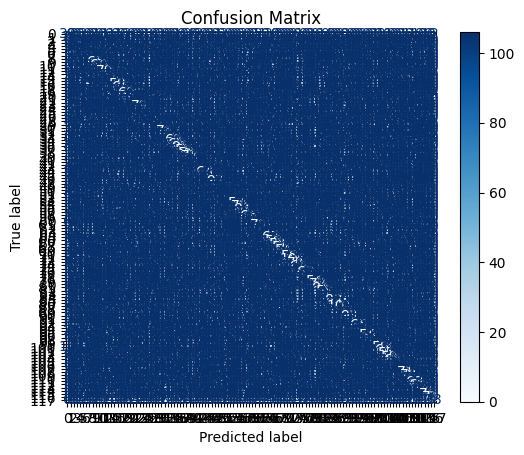

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.30      0.32       130
           1       0.30      0.22      0.25       130
           2       0.44      0.32      0.37       130
           3       0.35      0.27      0.31       130
           4       0.26      0.39      0.31       130
           5       0.39      0.32      0.35       130
           6       0.42      0.35      0.38       130
           7       0.28      0.25      0.27       130
           8       0.56      0.59      0.58        75
           9       0.57      0.50      0.53       130
          10       0.61      0.46      0.52       130
          11       0.70      0.35      0.46       130
          12       0.53      0.54      0.54       130
          13       0.34      0.39      0.37       130
          14       0.43      0.40      0.41       130
          15       0.23      0.30      0.26       130
          16       0.43      0.45      0.44       130
   

In [20]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 모델 평가를 위한 함수
def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels = []  # 모든 검증 레이블 저장
    all_preds = []   # 모든 예측 결과 저장

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())  # 모든 레이블 추가
            all_preds.extend(predicted.cpu().numpy())  # 모든 예측 추가

    return np.array(all_labels), np.array(all_preds)

# 혼동 행렬 및 분류 보고서 생성
def generate_confusion_matrix_and_report(all_labels, all_preds):
    # 혼동 행렬 생성
    confusion = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", confusion)

    # 혼동 행렬 시각화
    cmd = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels))
    cmd.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # 분류 보고서 출력
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in np.unique(all_labels)])
    print("Classification Report:\n", report)

# 평가 실행
all_labels, all_preds = evaluate_model(model, val_loader, device)
generate_confusion_matrix_and_report(all_labels, all_preds)


In [21]:
data_path = "Kaggle03"
with open(f"{data_path}/name2id.json") as f:
    class_name = json.load(f)
print(class_name)

class_name = [k for k, v in class_name.items()]
print(class_name)

{'Newfoundland': 0, 'Great_Dane': 1, 'Rhodesian_ridgeback': 2, 'miniature_schnauzer': 3, 'Chihuahua': 4, 'Scottish_deerhound': 5, 'Norwich_terrier': 6, 'cairn': 7, 'Mexican_hairless': 8, 'Sussex_spaniel': 9, 'papillon': 10, 'basenji': 11, 'German_short-haired_pointer': 12, 'Shih-Tzu': 13, 'Scotch_terrier': 14, 'Lakeland_terrier': 15, 'standard_schnauzer': 16, 'Ibizan_hound': 17, 'Japanese_spaniel': 18, 'curly-coated_retriever': 19, 'miniature_poodle': 20, 'Eskimo_dog': 21, 'American_Staffordshire_terrier': 22, 'Leonberg': 23, 'black-and-tan_coonhound': 24, 'Irish_wolfhound': 25, 'Appenzeller': 26, 'malamute': 27, 'Border_terrier': 28, 'Australian_terrier': 29, 'Afghan_hound': 30, 'Samoyed': 31, 'giant_schnauzer': 32, 'Great_Pyrenees': 33, 'Pembroke': 34, 'chow': 35, 'Bedlington_terrier': 36, 'Rottweiler': 37, 'Pomeranian': 38, 'Chesapeake_Bay_retriever': 39, 'collie': 40, 'Saluki': 41, 'affenpinscher': 42, 'Doberman': 43, 'Brittany_spaniel': 44, 'whippet': 45, 'French_bulldog': 46, 'Bl

In [22]:
class_correct = list(0. for i in range(len(class_name)))
class_total = list(0. for i in range(len(class_name)))


with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(class_name)):
    print(f'Accuracy of {class_name[i]} : {100 * class_correct[i] / class_total[i]} %')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy of Newfoundland : 30.76923076923077 %
Accuracy of Great_Dane : 23.076923076923077 %
Accuracy of Rhodesian_ridgeback : 27.692307692307693 %
Accuracy of miniature_schnauzer : 33.07692307692308 %
Accuracy of Chihuahua : 36.92307692307692 %
Accuracy of Scottish_deerhound : 33.84615384615385 %
Accuracy of Norwich_terrier : 34.61538461538461 %
Accuracy of cairn : 26.153846153846153 %
Accuracy of Mexican_hairless : 50.666666666666664 %
Accuracy of Sussex_spaniel : 46.92307692307692 %
Accuracy of papillon : 46.92307692307692 %
Accuracy of basenji : 31.53846153846154 %
Accuracy of German_short-haired_pointer : 54.61538461538461 %
Accuracy of Shih-Tzu : 40.0 %
Accuracy of Scotch_terrier : 43.07692307692308 %
Accuracy of Lakeland_terrier : 31.53846153846154 %
Accuracy of standard_schnauzer : 43.84615384615385 %
Accuracy of Ibizan_hound : 53.84615384615385 %
Accuracy of Japanese_spaniel : 61.03896103896104 %
Accuracy of curly-coated_retriever : 49.18032786885246 %
Accuracy of miniature_po

# Make SubmitFile

In [23]:
import pandas as pd

outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in test_loader:
    model.eval()
    with torch.no_grad():

        output = model(images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])